# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
import pandas as pd
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score   
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

import re 
import nltk
from nltk.corpus import stopwords as stopwords_nltk
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
! pip install wordcloud
from wordcloud import WordCloud, STOPWORDS



Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 366 kB 1.1 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


## Подготовка

In [3]:
df = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
df

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
pd.set_option('display.max_colwidth', -1)
display(df.head(10))

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0
9,alignment on this subject and which are contrary to those of DuLithgow,0


In [7]:
display(df.tail(10))

,text,toxic
159561,"""\nNo he did not, read it again (I would have thought everyone here could recite it by heart by now) it says """"Are we truly to believe the arbcom are so thankful for that, and Jimbo was ever so taken with her"""". The arbcom having read the evidence are now voting to thank her - so it is a very valid question. Kelly always implied she was a friend of Jimbo's. Good for her, that must be very pleasant for them both. However, I can't imagine Jimbo was particularly impressed by that blog either. If you actually read the blog, not just what was pasted to wiki, there is a lot of information on her views in other areas. I was also commenting on those. I don't imagine Jimbo is much impressed by me or many others concerned with whole rotten case either, but it's all a bit late for those concerns now. Now this is actually Bishonen's page, so my further views will be posted on my own page, if I decide to post them that is, because I too am heartily sick of this whole case, it is just a pity reference to that blog was ever permitted as evidence, especially if people do not in fact want to discuss it or here concerned parties views on it. """,0
159562,"""\n Auto guides and the motoring press are not good sources for an encyclopedia article about """"luxury vehicle"""". This is because automakers feed the press a lot of BS (Boastful Superlatives) who then work hard to write articles adding even more BS to describe their products. The press earns credits from the hands that feed them. Add to this the fact that potential and actual purchasers of luxury vehicles have an insatiable appetite for this type of BS. Classifying a particular vehicle as """"luxury"""" is also designed to easily make it superior to other vehicles even if the differences are superficial. Using self-serving BS in marketing claims is a very, very old invention that helps sell products, as well as fuel the fan base with """"bragging"""" rights to which vehicles are """"luxury"""". On the other hand, it is more difficult for most marketers to be humble and genuine. That is why an encyclopedia article has to avoid falling into the trap of using traditional marketing superlatives and hyperbole. — """,0
159563,"""\nplease identify what part of BLP applies because BLP clearly states that we must follow NPOV which says that we must present content in relation to the manner the subject is covered in reliable academic sources. In this case there has not been any substantial mainstream academic sources provided which is not critical of views and claims that Chopra makes. TRPoD aka The Red Pen of Doom \n""",0
159564,Catalan independentism is the social movement involving more people in Catalonia. Votes in the referendum at Barcelona were more than the ones received by political parties that are leading the council (PSC and CIU) . 20% of votes of the total census voting in favour of a referendum that is forbidden by spanish courts and that has no legal effects is highly relevant.,0
159565,"The numbers in parentheses are the additional decimal points which have been measured but lie outside the accuracy of the measurement process. This means the values in the parentheses eg (15) could be used for the purpose of calculation, but any value that results from such a calculation would not be more accurate than the number of significant figures if those in parentheses were not considered. In other words, the values in parentheses are there to help avoid rounding errors if you’re trying to work to the limit of accuracy of the gas constant. I agree that this is not commonly known, and only confuses the issue. I would recommend removing it.",0
159566,""":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can't even give a consistent argument - is the opening only supposed to mention significant aspects, or the """"most significant"""" ones? \n\n""",0
159567,You should be

In [8]:
df['toxic'].value_counts()

0    143346
1    16225 
Name: toxic, dtype: int64

In [9]:
df.duplicated().sum()

0

Анализ данных показал, что пустых значений и дубликатов нет. Можно считать, что почти каждый 10-ый комментарий - токсичный. Перед машинным обучением тексты необходимо предобработать - очистить комментарии от лишних знаков, провести токенизацию (разбить комментарии на отдельные фразы, слова) и лемматизацию текста (привести слова к начальной форме), а также удалить стоп-слова. Проведем эти операции.

### Удаление лишних символов

In [10]:
def remove(text):
    clean_text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return clean_text

df['new_text'] = df['text'].apply(lambda x: remove(x.lower()))
df.tail(5)

,text,toxic,new_text
159566,""":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can't even give a consistent argument - is the opening only supposed to mention significant aspects, or the """"most significant"""" ones? \n\n""",0,and for the second time of asking when your view completely contradicts the coverage in reliable sources why should anyone care what you feel you can t even give a consistent argument is the opening only supposed to mention significant aspects or the most significant ones
159567,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61.19.93,0,you should be ashamed of yourself that is a horrible thing you put on my talk page
159568,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0,spitzer umm theres no actual article for prostitution ring crunch captain
159569,And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.,0,and it looks like it was actually you who put on the speedy to have the first version deleted now that i look at it
159570,"""\nAnd ... I really don't think you understand. I came here and my idea was bad right away. What kind of community goes """"you have bad ideas"""" go away, instead of helping rewrite them. """,0,and i really don t think you understand i came here and my idea was bad right away what kind of community goes you have bad ideas go away instead of helping rewrite them


### Удаление стоп слов

In [11]:
stop_words = set(stopwords_nltk.words('english'))  

def remove_stopwords(text):
    clean_text = [x for x in text.split() if not x in stop_words]  
    return clean_text

df['without_stopwords'] = df['new_text'].apply(lambda x: remove_stopwords(x))
df.head(5)

,text,toxic,new_text,without_stopwords
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now,"[explanation, edits, made, username, hardcore, metallica, fan, reverted, vandalisms, closure, gas, voted, new, york, dolls, fac, please, remove, template, talk, page, since, retired]"
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,d aww he matches this background colour i m seemingly stuck with thanks talk january utc,"[aww, matches, background, colour, seemingly, stuck, thanks, talk, january, utc]"
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info,"[hey, man, really, trying, edit, war, guy, constantly, removing, relevant, information, talking, edits, instead, talk, page, seems, care, formatting, actual, info]"
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,more i can t make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it s listed in the relevant form eg wikipedia good article nominations transport,"[make, real, suggestions, improvement, wondered, section, statistics, later, subsection, types, accidents, think, references, may, need, tidying, exact, format, ie, date, format, etc, later, one, else, first, preferences, formatting, style, references, want, please, let, know, appears, backlog, articles, review, guess, may, delay, reviewer, turns, listed, relevant, form, eg, wikipedia, good, article, nominations, transport]"
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,you sir are my hero any chance you remember what page that s on,"[sir, hero, chance, remember, page]"


### Лемматизация

In [12]:
lemmatizer = nltk.WordNetLemmatizer()

def lemmatize_words(text):
    clean_text = [lemmatizer.lemmatize(word) for word in text]
    return clean_text

df['lemmas'] = df['without_stopwords'].apply(lambda x: lemmatize_words(x))
df.head(5)

,text,toxic,new_text,without_stopwords,lemmas
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now,"[explanation, edits, made, username, hardcore, metallica, fan, reverted, vandalisms, closure, gas, voted, new, york, dolls, fac, please, remove, template, talk, page, since, retired]","[explanation, edits, made, username, hardcore, metallica, fan, reverted, vandalism, closure, gas, voted, new, york, doll, fac, please, remove, template, talk, page, since, retired]"
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,d aww he matches this background colour i m seemingly stuck with thanks talk january utc,"[aww, matches, background, colour, seemingly, stuck, thanks, talk, january, utc]","[aww, match, background, colour, seemingly, stuck, thanks, talk, january, utc]"
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info,"[hey, man, really, trying, edit, war, guy, constantly, removing, relevant, information, talking, edits, instead, talk, page, seems, care, formatting, actual, info]","[hey, man, really, trying, edit, war, guy, constantly, removing, relevant, information, talking, edits, instead, talk, page, seems, care, formatting, actual, info]"
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,more i can t make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it s listed in the relevant form eg wikipedia good article nominations transport,"[make, real, suggestions, improvement, wondered, section, statistics, later, subsection, types, accidents, think, references, may, need, tidying, exact, format, ie, date, format, etc, later, one, else, first, preferences, formatting, style, references, want, please, let, know, appears, backlog, articles, review, guess, may, delay, reviewer, turns, listed, relevant, form, eg, wikipedia, good, article, nominations, transport]","[make, real, suggestion, improvement, wondered, section, statistic, later, subsection, type, accident, think, reference, may, need, tidying, exact, format, ie, date, format, etc, later, one, else, first, preference, format

Построим облака слов для все комментариев, нейтральных, и токсичных.

In [13]:
words = list(itertools.chain.from_iterable(df['lemmas']))
neutral = df.query('toxic == 0')
neutral_words = list(itertools.chain.from_iterable(neutral['lemmas']))
toxic = df.query('toxic == 1')
toxic_words = list(itertools.chain.from_iterable(toxic['lemmas']))

In [14]:
toxic

,text,toxic,new_text,without_stopwords,lemmas
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker before you piss around on my work,"[cocksucker, piss, around, work]","[cocksucker, piss, around, work]"
12,"Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...",1,hey what is it talk what is it an exclusive group of some wp talibans who are good at destroying self appointed purist who gang up any one who asks them questions abt their anti social and destructive non contribution at wp ask sityush to clean up his behavior than issue me nonsensical warnings,"[hey, talk, exclusive, group, wp, talibans, good, destroying, self, appointed, purist, gang, one, asks, questions, abt, anti, social, destructive, non, contribution, wp, ask, sityush, clean, behavior, issue, nonsensical, warnings]","[hey, talk, exclusive, group, wp, taliban, good, destroying, self, appointed, purist, gang, one, asks, question, abt, anti, social, destructive, non, contribution, wp, ask, sityush, clean, behavior, issue, nonsensical, warning]"
16,"Bye! \n\nDon't look, come or think of comming back! Tosser.",1,bye don t look come or think of comming back tosser,"[bye, look, come, think, comming, back, tosser]","[bye, look, come, think, comming, back, tosser]"
42,"You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...\n\n1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!\n\n2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!\n\n3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!\n\nBeware of the Dark Side!",1,you are gay or antisemmitian archangel white tiger meow greetingshhh uh there are two ways why you do erased my comment about ww that holocaust was brutally slaying of jews and not gays gypsys slavs anyone if you are anti semitian than shave your head bald and go to the skinhead meetings if you doubt words of the bible that homosexuality is a deadly sin make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals first and last warning you fucking gay i won t appreciate if any more nazi shwain would write in my page i don t wish to talk to you anymore beware of the dark side,"[gay, antisemmitian, archangel, white, tiger, meow, greetingshhh, uh, two, ways, erased, comment, ww, holocaust, brutally, slaying, jews, gays, gypsys, slavs, anyone, anti, semitian, shave, head, bald, go, skinhead, meetings, doubt, words, bible, homosexuality, deadly, sin, make, pentagram, tatoo, forehead, go, satanistic, masses, gay, pals, first, last, warning, fucking, gay, appreciate, nazi, shwain, would, write, page, wish, talk, anymore, beware, dark, side]","[gay, antisemmitian, archangel, white, tiger, meow, greetingshhh, uh, two, way, erased, comment, ww, holocaust, brutally, slaying, jew, gay, gypsy, slav, anyone, anti, semitian, shave, head, bald, go, skinhead, meeting, doubt, word, bible, homosexuality, deadly, sin, make, pentagram, tatoo, forehead, go, satanistic, mass, gay, pal, first, last, warning, fucking, gay, appreciate, nazi, shwain, would, write, page, wish, talk, anymore, beware, dark, side]"
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,fuck your filthy mother in the ass dry,"[fuck, filthy, mother, ass, dry]","[fuck, filthy, mother, as, dry]"
...,...,...,...,...,...
159494,"""\n\n our previous conversation \n\nyou fucking shit eating liberal, you make lady bir

In [15]:
type_of_comments = {'Облако слов для всех комментариев' : words, 
                             'Облако слов для нейтральных комментариев': neutral_words, 
                             'Облако слов для токсичных комментариев': toxic_words}

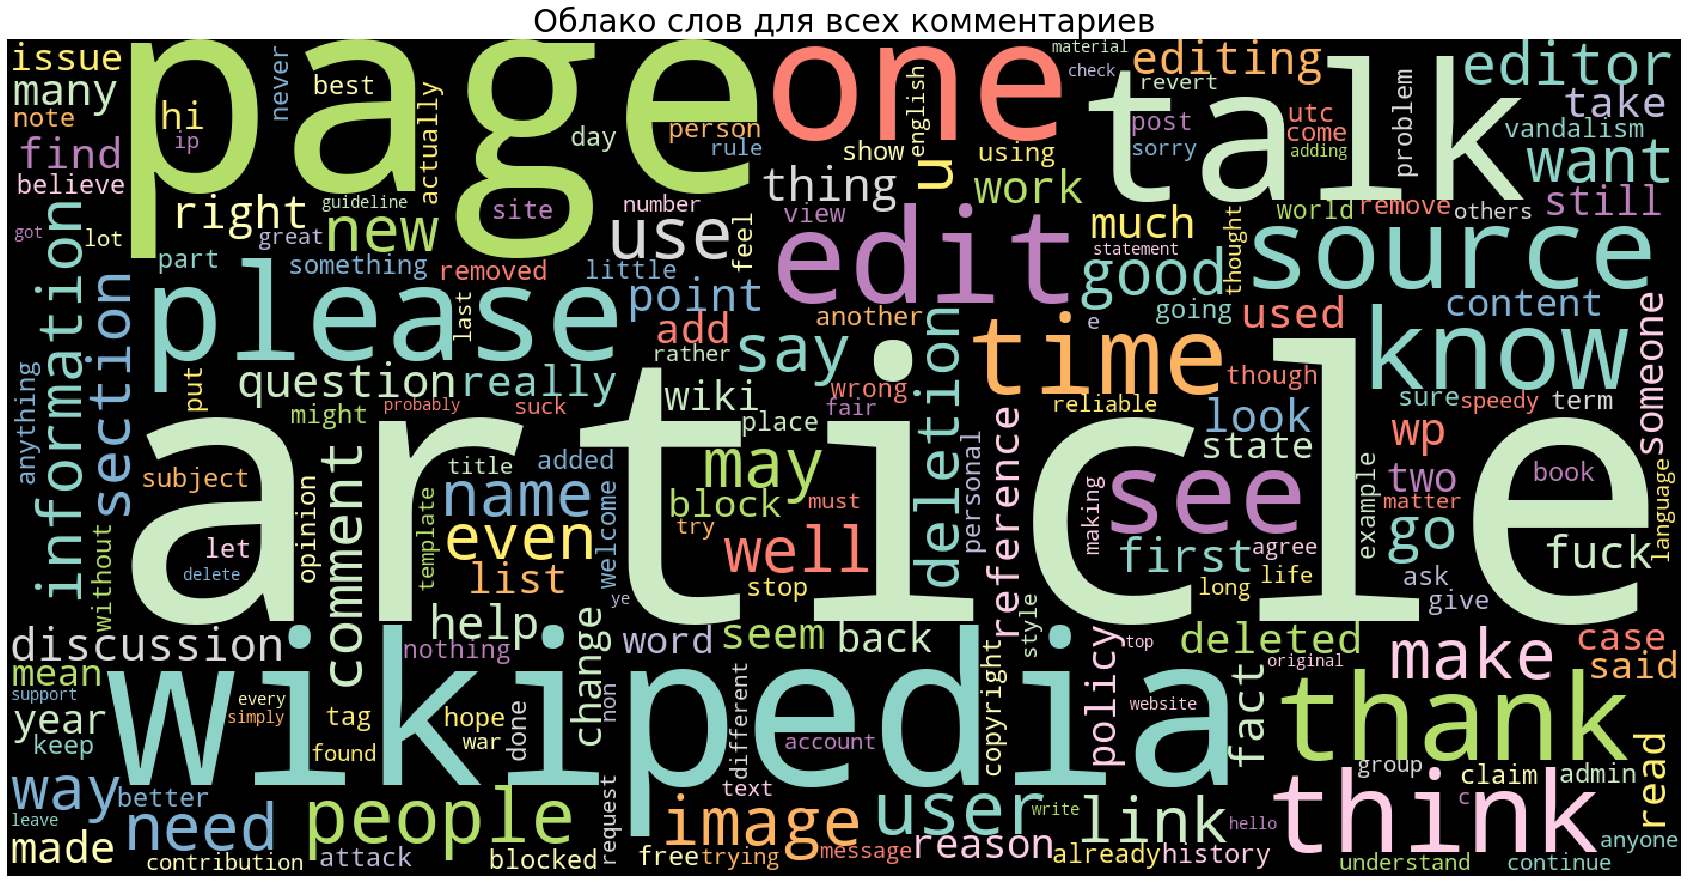

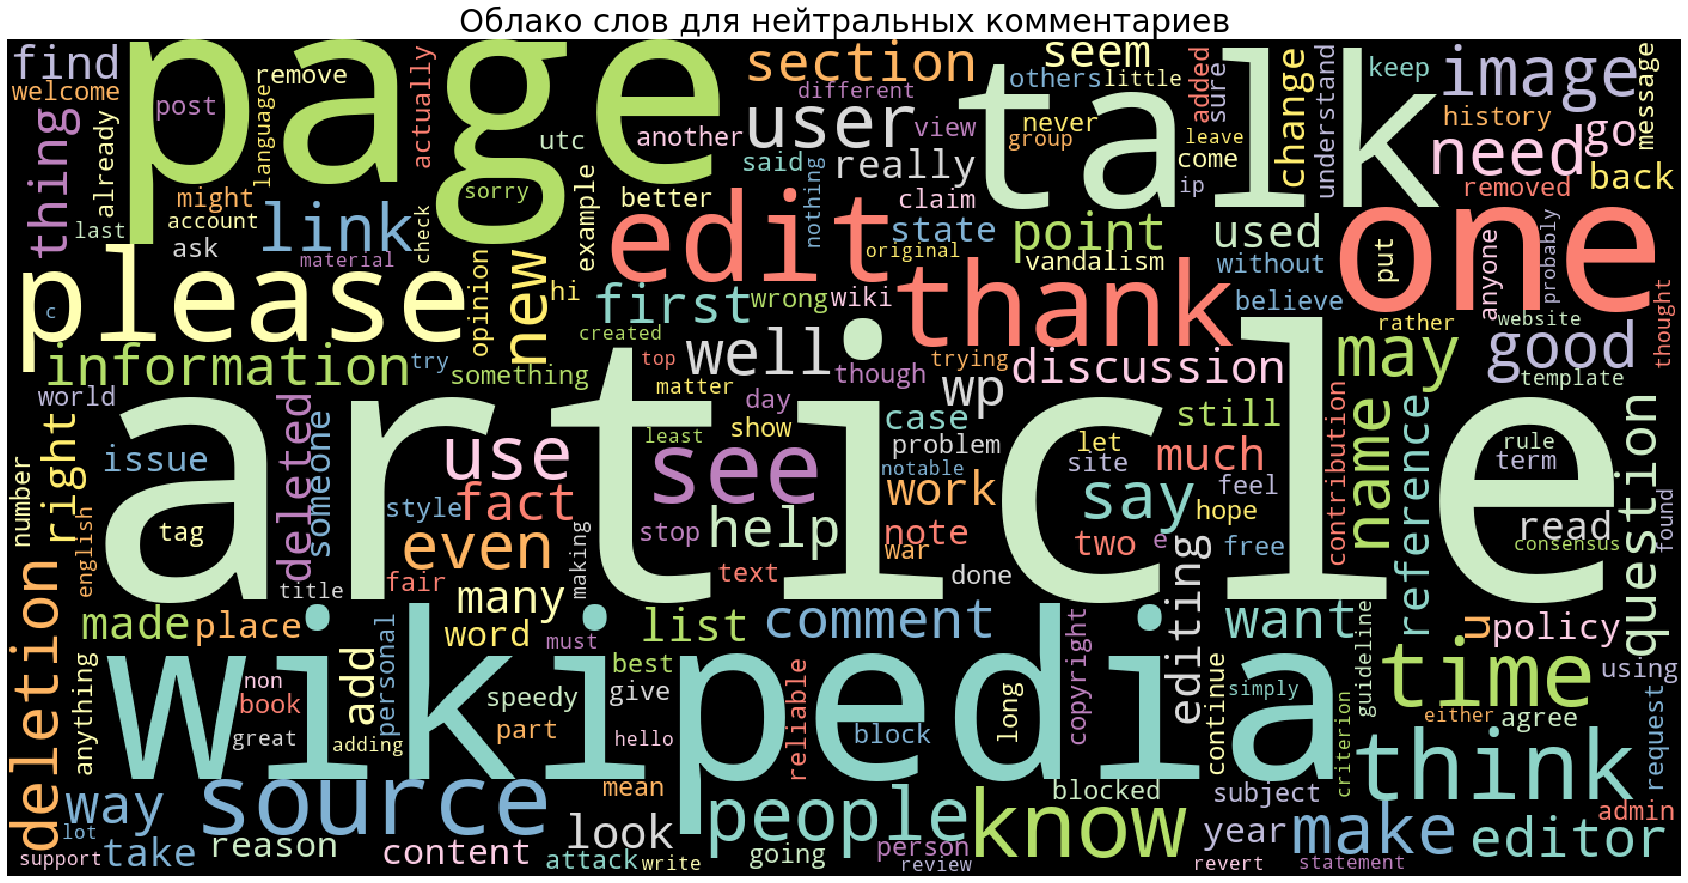

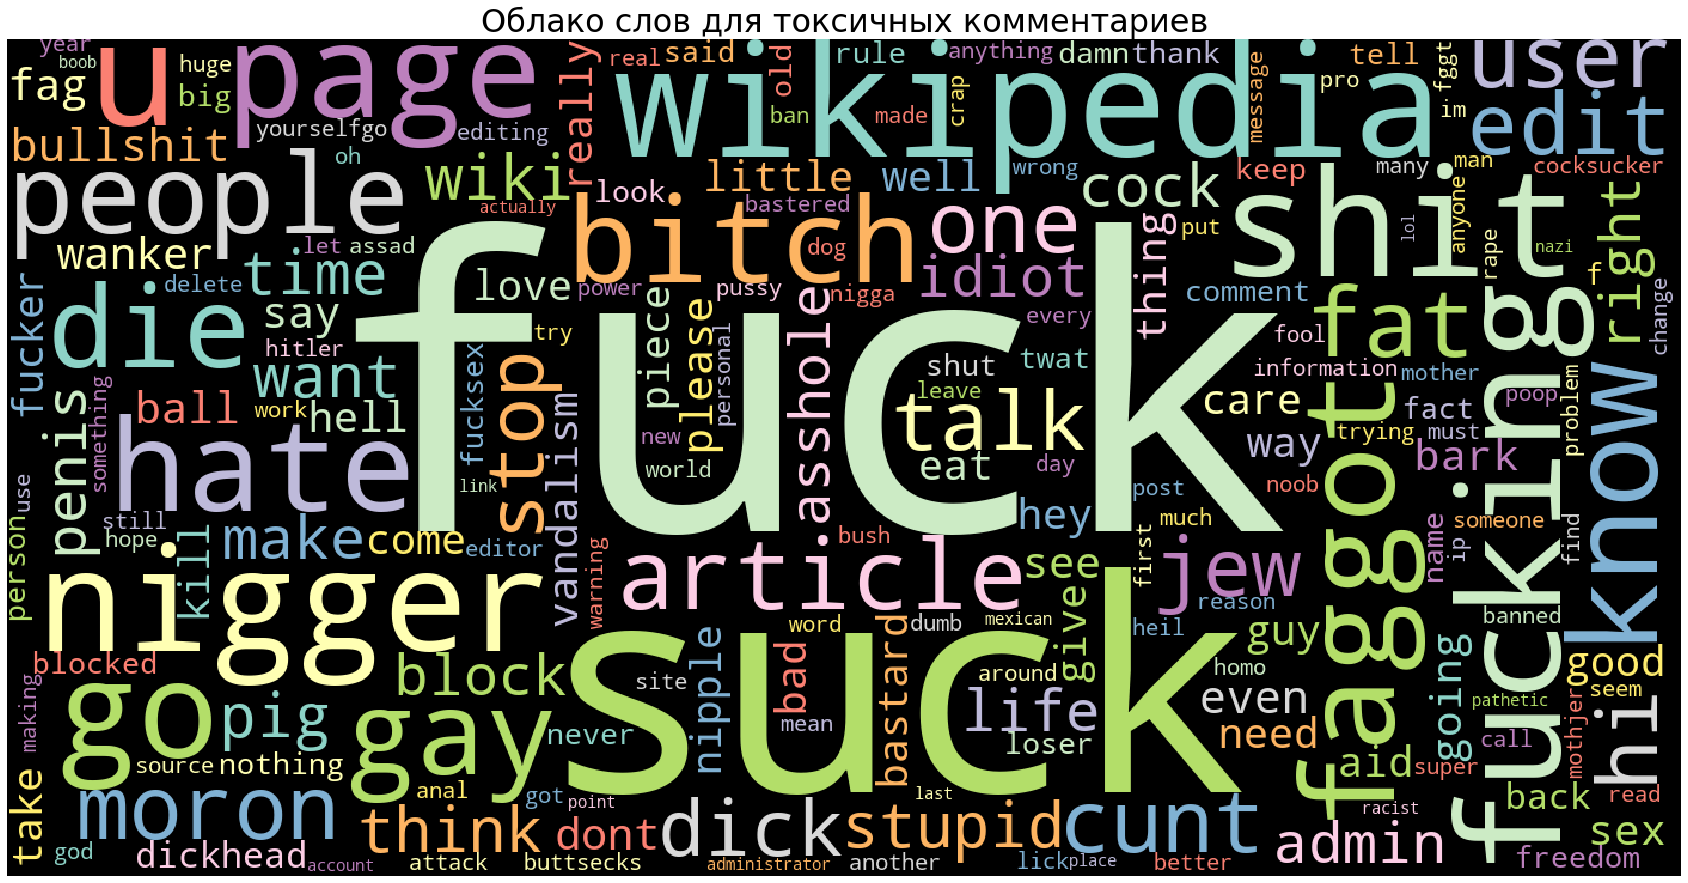

In [16]:
for key, value in type_of_comments.items():
    
    wordcloud = WordCloud(random_state=123, 
                          width = 1400, 
                          height = 700,
                          background_color='black', 
                          colormap='Set3', 
                          collocations=False, 
                          stopwords = STOPWORDS).generate(' '.join(x for x in value))
    
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis('off')
    plt.title(key, fontsize=32)

Получили список наиболее встречающихся слов в двух видах комментариев. 

### Подготовим обучающую и тестовую выборки

In [17]:
target = df['toxic']
features = df.drop('toxic', axis = 1)

In [18]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)

In [19]:
corpus_train = features_train['lemmas'].astype('U')
corpus_test = features_test['lemmas'].astype('U')

In [20]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
tf_idf = count_tf_idf.fit(corpus_train)


In [21]:
train_tf_idf = tf_idf.transform(corpus_train)
test_tf_idf = tf_idf.transform(corpus_test)

## Обучение

In [22]:
res = []

In [23]:
def model(model_name):
    model = model_name
    model.fit(train_tf_idf, target_train)
    predicted_test = model.predict(test_tf_idf)
    
    res.append({'Модель': model, 
                'F1': f1_score(target_test, predicted_test)})
    return res

In [24]:
model_lr = model(LogisticRegression(random_state=12345, class_weight='balanced') )

In [25]:
model_dtf = model(DecisionTreeClassifier(random_state=12345, max_depth=5))

In [26]:
model_rfc = model(RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=15, class_weight='balanced'))

In [27]:
res = pd.DataFrame(res)
res['Модель']=['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier']

In [28]:
res

,Модель,F1
0,LogisticRegression,0.751985
1,DecisionTreeClassifier,0.500985
2,RandomForestClassifier,0.374404


Попробуем улучшить DecisionTreeClassifier

In [29]:
def f1_scoring(target, predictions):
    f1 = f1_score(target, predictions)
    return f1
F1_score = make_scorer(f1_scoring, greater_is_better=True )

In [30]:
max_depth = [10,100,200,250]

hyperparameter_grid = {
    'max_depth': max_depth,
}


model = DecisionTreeClassifier(random_state = 12345)


random_cv = GridSearchCV(estimator=model,
    param_grid=hyperparameter_grid,
    cv=2, 
    scoring = F1_score,
    n_jobs = -1, verbose = 1, 
    return_train_score = True)


random_cv.fit(train_tf_idf, target_train) 

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  8.6min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=12345,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [10, 100, 200, 250]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
  

In [31]:
predicted_test = random_cv.predict(test_tf_idf)
print (f1_score(target_test, predicted_test))

0.7195767195767195


In [32]:
random_cv.best_params_

{'max_depth': 200}

In [33]:
final_results = pd.DataFrame(random_cv.cv_results_)
final_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,12.715097,0.224605,0.093344,0.000280,10,{'max_depth': 10},0.577239,0.586506,0.581872,0.004634,4,0.610131,0.612615,0.611373,0.001242
1,58.122689,0.544731,0.114450,0.000275,100,{'max_depth': 100},0.712247,0.717846,0.715047,0.002800,2,0.879742,0.882450,0.881096,0.001354
2,97.948922,1.482925,0.145539,0.004029,200,{'max_depth': 200},0.713468,0.720309,0.716889,0.003421,1,0.929724,0.928887,0.929305,0.000419
3,89.499967,10.150245,0.113746,0.001318,250,{'max_depth': 250},0.712612,0.713605,0.713109,0.000497,3,0.943705,0.944184,0.943944,0.000239


Как видно, показатель не слишком вырос. Попробуем тогда изменить пороговое значение для DecisionTreeClassifier.

In [34]:
model = DecisionTreeClassifier(random_state=12345, max_depth=200)
model.fit(train_tf_idf, target_train)
probabilities_test = model.predict_proba(test_tf_idf)
probabilities_one_test = probabilities_test[:, 1]


In [35]:
for threshold in np.arange(0, 0.8, 0.02):
    predicted_valid =  probabilities_one_test > threshold 
    f1 = f1_score(target_test, predicted_valid)

    print("Порог = {:.2f} |  F1 = {:.3f}".format(
        threshold, f1)) 

Порог = 0.00 |  F1 = 0.171
Порог = 0.02 |  F1 = 0.210
Порог = 0.04 |  F1 = 0.715
Порог = 0.06 |  F1 = 0.718
Порог = 0.08 |  F1 = 0.718
Порог = 0.10 |  F1 = 0.718
Порог = 0.12 |  F1 = 0.720
Порог = 0.14 |  F1 = 0.720
Порог = 0.16 |  F1 = 0.720
Порог = 0.18 |  F1 = 0.720
Порог = 0.20 |  F1 = 0.720
Порог = 0.22 |  F1 = 0.720
Порог = 0.24 |  F1 = 0.720
Порог = 0.26 |  F1 = 0.720
Порог = 0.28 |  F1 = 0.720
Порог = 0.30 |  F1 = 0.720
Порог = 0.32 |  F1 = 0.720
Порог = 0.34 |  F1 = 0.720
Порог = 0.36 |  F1 = 0.720
Порог = 0.38 |  F1 = 0.720
Порог = 0.40 |  F1 = 0.720
Порог = 0.42 |  F1 = 0.720
Порог = 0.44 |  F1 = 0.720
Порог = 0.46 |  F1 = 0.720
Порог = 0.48 |  F1 = 0.720
Порог = 0.50 |  F1 = 0.720
Порог = 0.52 |  F1 = 0.720
Порог = 0.54 |  F1 = 0.720
Порог = 0.56 |  F1 = 0.720
Порог = 0.58 |  F1 = 0.720
Порог = 0.60 |  F1 = 0.719
Порог = 0.62 |  F1 = 0.719
Порог = 0.64 |  F1 = 0.719
Порог = 0.66 |  F1 = 0.719
Порог = 0.68 |  F1 = 0.719
Порог = 0.70 |  F1 = 0.719
Порог = 0.72 |  F1 = 0.719
П

Увеличить до необходимого показателя 0.75 для данной модели не получилось. 

## Выводы

<p>Во время предоработки данных мы очистили комментарии от лишних знаков, стоп-слов. Привели слова к леммам и рассчитали наиболее часто встречающиеся слова в зависимости от типа комментария. </p>
<p> Для решения задачи классификации использовались модели LogisticRegression,DecisionTreeClassifier,RandomForestClassifier. Наилучший показатель F1 получился у модели LogisticRegression - 0.751985. Были попытки улучшить F1 для DecisionTreeClassifier, но до нужного значения добраться не получилось. Теоретически можно было еще попробовать вариант с увеличинием выборок, но так как данная задача решилась с помощью LogisticRegression, данный вариант не рассматривался.</p>